<a href="https://colab.research.google.com/github/PerlaMolina/BMI212-AURA/blob/main/Copy_of_extracted_FC_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

the purpose of this notebook was to see if extracted Functional Connectome features (from autoencoder) would perform better on non-linear classifier

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
# load data
from google.colab import drive
import pandas as pd
drive.mount('/content/drive/')
file_path = '/content/drive/My Drive/widsdata/'
behavorial_data = pd.read_excel(file_path+'TRAIN_QUANTITATIVE_METADATA_new.xlsx')
label_data = pd.read_excel(file_path+'TRAINING_SOLUTIONS.xlsx')
FC_data = pd.read_csv(file_path+ 'TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
FC_reduced = pd.read_csv(file_path+ 'autoencoder/FC_extracted.csv')

# Lan Lan wrote the code in this notebook.
Using device: cuda
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from random import seed
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
seed (0)
# merge everything first because need to drop subject with nan entries for all data
all_data_with_label = pd.merge(behavorial_data, label_data, how= 'left', on= ['participant_id'])
all_data_with_label = pd.merge(all_data_with_label, FC_data, how= 'left', on= ['participant_id']) # merge with raw FC data
all_data_with_label = pd.merge(all_data_with_label, FC_reduced, how= 'left', on= ['participant_id']) # merge with extracted FC data
all_data_with_label['stratify'] = all_data_with_label['Sex_F'].astype(str) + '_' + all_data_with_label['ADHD_Outcome'].astype(str)
# drop NAN
all_data_with_label = all_data_with_label.dropna()
# drop columns not related to ADHD: "EHQ_EHQ_Total" - Laterality Index (Score), "ColorVision_CV_Score" - Color vision test score
all_data_with_label = all_data_with_label.drop(columns=['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'MRI_Track_Age_at_Scan'])

# before splitting, standardize behavorial features

behavorial_columns_names = [x for x in behavorial_data.columns
                            if x not in ['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'MRI_Track_Age_at_Scan']]


scaler = StandardScaler()
all_data_with_label[behavorial_columns_names] = scaler.fit_transform(all_data_with_label[behavorial_columns_names])


# splitting
train_all_subjects_raw, test_all_subjects_raw = train_test_split(all_data_with_label, test_size=0.3, stratify=all_data_with_label['stratify'])
print('training:')
print(train_all_subjects_raw['stratify'].value_counts())
print('testing:')
print(test_all_subjects_raw['stratify'].value_counts())
train_all_subjects_raw.reset_index(drop=True, inplace=True)
test_all_subjects_raw.reset_index(drop=True, inplace=True)

# training data for all subjects
train_data_all_subjects_X = train_all_subjects_raw.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify', 'Unnamed: 0'])
train_data_all_subjects_y = train_all_subjects_raw['ADHD_Outcome']

# training data for female
train_data_female_X = train_all_subjects_raw[train_all_subjects_raw['Sex_F'] == 1].drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
train_data_female_y = train_all_subjects_raw[train_all_subjects_raw['Sex_F'] == 1]['ADHD_Outcome']


# training data for male
train_data_male_X = train_all_subjects_raw[train_all_subjects_raw['Sex_F'] == 0].drop(columns = ['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
train_data_male_y = train_all_subjects_raw[train_all_subjects_raw['Sex_F'] == 0]['ADHD_Outcome']

# testing data for all subjects
test_data_all_subjects_X = test_all_subjects_raw.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
test_data_all_subjects_y = test_all_subjects_raw['ADHD_Outcome']

# testing data for female
test_data_female_X = test_all_subjects_raw[test_all_subjects_raw['Sex_F'] == 1].drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
test_data_female_y = test_all_subjects_raw[test_all_subjects_raw['Sex_F'] == 1]['ADHD_Outcome']

# testing data for male
test_data_male_X = test_all_subjects_raw[test_all_subjects_raw['Sex_F'] == 0].drop(columns = ['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
test_data_male_y = test_all_subjects_raw[test_all_subjects_raw['Sex_F'] == 0]['ADHD_Outcome']


def make_data_dictionary(columns_to_select):

  #all variables not passed in are initialized perviously as global variables for this function
  data_dictionary = {
     'all_subjects': {
        'train_X': train_data_all_subjects_X[columns_to_select],
        'train_y': train_data_all_subjects_y,
        'test_X': test_data_all_subjects_X[columns_to_select],
        'test_y': test_data_all_subjects_y},
    'female': {
        'train_X': train_data_female_X[columns_to_select],
        'train_y': train_data_female_y,
        'test_X': test_data_female_X[columns_to_select],
        'test_y': test_data_female_y},
    'male': {
        'train_X': train_data_male_X[columns_to_select],
        'train_y': train_data_male_y,
        'test_X': test_data_male_X[columns_to_select],
        'test_y': test_data_male_y}
 }

  return data_dictionary

behavorial_columns_names = [x for x in behavorial_data.columns
                            if x not in ['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'MRI_Track_Age_at_Scan']]

raw_FC_columns_names = [x for x in FC_data.columns if 'row' in x and 'column' in x and 'th' in x]

reduced_FC_columns_names = [x for x in FC_reduced.columns if 'extracted_FC' in x]

behavorial_data_dictionary = make_data_dictionary(behavorial_columns_names)
raw_FC_data_dictionary = make_data_dictionary(raw_FC_columns_names)
reduced_FC_data_dictionary = make_data_dictionary(reduced_FC_columns_names)

training:
stratify
0_1    274
1_1    115
0_0    102
1_0     77
Name: count, dtype: int64
testing:
stratify
0_1    118
1_1     49
0_0     44
1_0     33
Name: count, dtype: int64


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class FC_reduced_classifier(nn.Module):
    def __init__(self):
        super().__init__()      ### init the super class

        latent_dim = [30, 15] # arbitrary chosen (in general *0.5 or less of the previous layer)

        network = []
        prev_dim = 50

        for dim in latent_dim:
            network.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim),
                nn.ReLU(),
                nn.Dropout(0.5) # have tried different dropout rates, did not change the results much
            ])
            prev_dim = dim


        num_classes = 2

        network.append(nn.Linear(prev_dim, num_classes))


        self.network = nn.Sequential(*network)



    def forward(self, x):


        return self.network(x)

    def predict(self, x):

        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
            return predictions

    def predict_proba(self, x):

        with torch.no_grad():
            logits = self.forward(x)
            probabilities = F.softmax(logits, dim=1)
            return probabilities


from torch.utils.data import Dataset, DataLoader

class LoadWidsDataset(Dataset):
    def __init__(self, train_df, label_column, transform=None):

      train_df_copy = train_df.copy().reset_index(drop=True)
      self.dataframe = train_df_copy
      self.transform = transform
      self.features = train_df_copy.drop(columns=[label_column])
      self.labels = train_df_copy[label_column]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        feature = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)

        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return feature, label


In [ ]:
from torch.nn import CrossEntropyLoss
import torch.optim as optim
import matplotlib.pyplot as plt
def train_model(model, all_subject_loader, cohort_name, num_epochs):
  # training

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(all_subject_model.parameters(), lr=0.001, weight_decay=1e-4)

  train_losses = []
  #num_epochs = 1000

  for epoch in range(num_epochs):

      all_subject_model.train()
      train_loss = 0.0
      num_batches = 0

      for FC_data_i, labels in all_subject_loader :
          FC_data_i, labels = FC_data_i.to(device), labels.to(device)

          logits= all_subject_model(FC_data_i)
          loss = criterion(logits, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          num_batches += 1


      train_losses.append(train_loss / num_batches)


  fig, ax = plt.subplots(1,1)
  ax.plot(train_losses)
  plt.title('Loss over epochs for ' + cohort_name)
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy loss')
  plt.show()


  return all_subject_model, train_losses

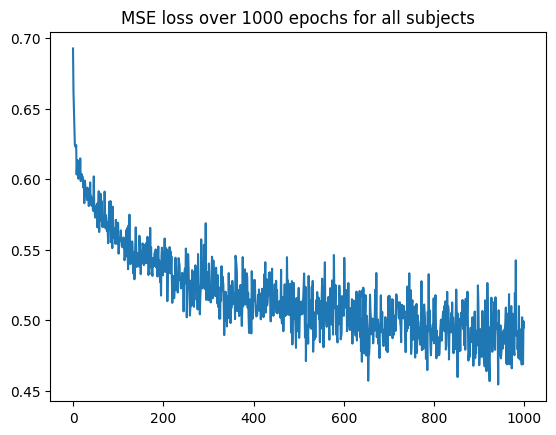

In [ ]:
all_subject_FC_df = reduced_FC_data_dictionary['all_subjects']['train_X'].copy()
all_subject_FC_df['ADHD_Outcome'] = reduced_FC_data_dictionary['all_subjects']['train_y']

# data loader
all_subject_loader = DataLoader(LoadWidsDataset(all_subject_FC_df,label_column = 'ADHD_Outcome' ),
                                             batch_size= 50, shuffle=True)
all_subject_model = FC_reduced_classifier().to(device)
all_subject_model, all_subject_loss = train_model(all_subject_model, all_subject_loader, 'all subjects')

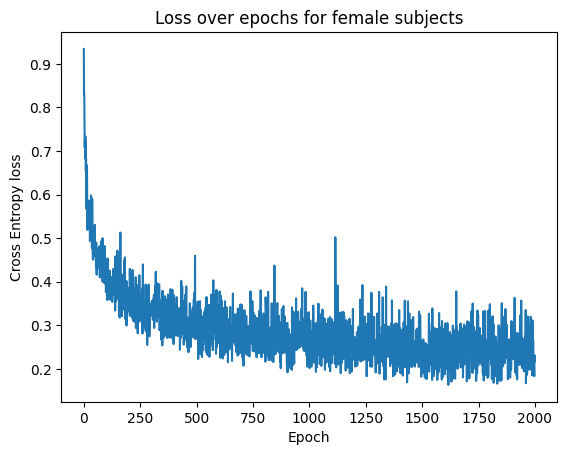

In [ ]:
female_df = reduced_FC_data_dictionary['female']['train_X'].copy()
female_df['ADHD_Outcome'] = reduced_FC_data_dictionary['female']['train_y']
# data loader
female_loader = DataLoader(LoadWidsDataset(female_df,label_column = 'ADHD_Outcome' ),
                                             batch_size= 50, shuffle=True)
female_model = FC_reduced_classifier().to(device)
female_model, female_loss = train_model(female_model, female_loader, 'female subjects', 2000)

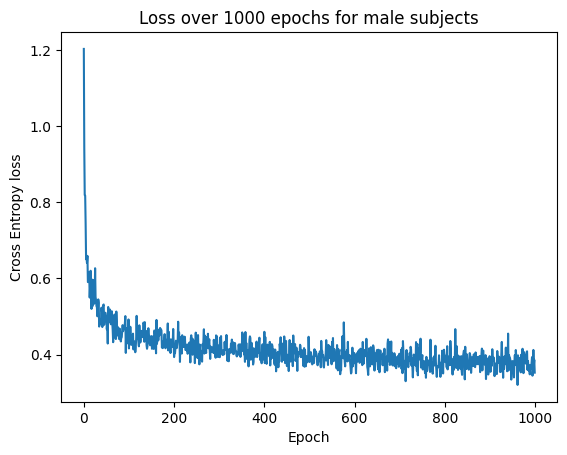

In [ ]:
male_df = reduced_FC_data_dictionary['male']['train_X'].copy()
male_df['ADHD_Outcome'] = reduced_FC_data_dictionary['male']['train_y']
# data loader
male_loader = DataLoader(LoadWidsDataset(male_df,label_column = 'ADHD_Outcome' ),
                                             batch_size= 50, shuffle=True)
male_model = FC_reduced_classifier().to(device)
male_model, male_loss = train_model(male_model, male_loader, 'male subjects')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
def evaluate_model(model, test_loader):
    """Evaluate the trained model with comprehensive metrics"""

    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    all_predictions = []
    all_probabilities = []
    all_labels = []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)


            predictions = model.predict(features)
            probabilities = model.predict_proba(features)

            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_predictions)


    positive_class_probs = all_probabilities[:, 1]
    auroc = roc_auc_score(all_labels, positive_class_probs)


    report = classification_report(all_labels, all_predictions)

    fpr, tpr, thresholds = roc_curve(all_labels, positive_class_probs)

    return {
        'accuracy': accuracy,
        'auroc': auroc,
        'classification_report': report,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities,
        'roc_data': (fpr, tpr, thresholds)
    }

def plot_roc_curve(fpr, tpr, auroc):
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUROC = {auroc:.3f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.grid(True, alpha=0.3)
  plt.show()

female auroc: 0.512


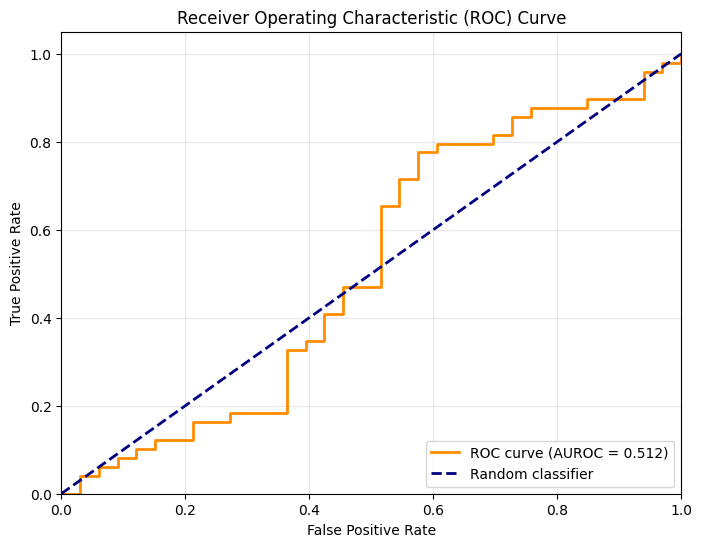

In [ ]:
female_test_df = reduced_FC_data_dictionary['female']['test_X'].copy()
female_test_df['ADHD_Outcome'] = reduced_FC_data_dictionary['female']['test_y']

female_test_loader = DataLoader(LoadWidsDataset(female_test_df,label_column = 'ADHD_Outcome' ),
                                             batch_size= len(female_test_df), shuffle=True)
results_female = evaluate_model(female_model, female_test_loader)
print('female auroc: ' + str(np.round(results_female['auroc'], 3)))
fpr, tpr, _ = results_female['roc_data']
auroc = results_female['auroc']
plot_roc_curve(fpr, tpr, auroc)

In [ ]:
all_subject_test_df = reduced_FC_data_dictionary['all_subjects']['test_X'].copy()
all_subject_test_df['ADHD_Outcome'] = reduced_FC_data_dictionary['all_subjects']['test_y']

all_subject_test_loader = DataLoader(LoadWidsDataset(all_subject_test_df,label_column = 'ADHD_Outcome' ),
                                             batch_size= len(all_subject_test_df), shuffle=True)
results_all_subjects = evaluate_model(all_subject_model, all_subject_test_loader)
print('all subject auroc: ')
results_all_subjects['auroc']


all subject auroc: 


np.float64(0.5348782953573372)

In [ ]:
male_test_df = reduced_FC_data_dictionary['male']['test_X'].copy()
male_test_df['ADHD_Outcome'] = reduced_FC_data_dictionary['male']['test_y']
male_test_loader = DataLoader(LoadWidsDataset(male_test_df,label_column = 'ADHD_Outcome' ),
                                             batch_size= len(male_test_df), shuffle=True)
results_male = evaluate_model(male_model, male_test_loader)
print('male auroc: ' + str(np.round(results_male['auroc'], 3)))

male auroc: 0.532


In [ ]:
# save model
save_path = file_path + 'reduced_FC_classifier/'
torch.save(female_model.state_dict(), save_path+'female_model')
torch.save(male_model.state_dict(), save_path+'male_model')
torch.save(all_subject_model.state_dict(), save_path+'all_subject_model')
